# Settemezzo using Reinforcement Learning

The aim of this project is to produce a Blackjack strategy using decaying epsilon-greedy Q-learning that will earn more than the average casino player.     

Accompanying [report](https://github.com/Pradhyo/blackjack/blob/master/report.md) has additional information.

### Payout when taking random action each round

The actions and corresponding payouts of the average casino player are simulated using the Open AI blackjack environment mentioned above. 

In [2]:
import gym
import gym_banana
import matplotlib.pyplot as plt

env = gym.make('Settemezzo-v0')
env.reset()

num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 1000 # num_rounds simulated over num_samples

average_payouts = []

for sample in range(num_samples):
    round = 1
    total_payout = 0 # to store total payout over 'num_rounds'
    
    while round <= num_rounds:
        action = env.action_space.sample()  # take random action 
        obs, payout, is_done, _ = env.step(action)
        total_payout += payout
        if is_done:
            env.reset() # Environment deals new cards to player and dealer
            round += 1
    average_payouts.append(total_payout)

plt.plot(average_payouts)                
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()    
print ("Average payout after {}  rounds is {}".format(num_rounds, sum(average_payouts)/num_samples))

ModuleNotFoundError: No module named 'gym_banana'

### Payout when using normal play strategy
Strategy from figure 11 [here](https://pdfs.semanticscholar.org/e1dd/06616e2d18179da7a3643cb3faab95222c8b.pdf) is simulated to find out the average payout/1000 rounds for one of the well-known strategies.

In [6]:
def normal_strategy(player_sum, dealer_up_card):
    """
    Returns appropriate action from a 2D array storing actions
    Actions obtained from figure 11 here- https://pdfs.semanticscholar.org/e1dd/06616e2d18179da7a3643cb3faab95222c8b.pdf
    Each row corresponds to player sum- from 2 to 21
    Each column corresponds to dealer_up_card- from 1 to 10
    """
    actions = [[1]*10]*8 # 2 to 9
    actions.append([1]*4 + [0]*2 + [1]*4) #10
    actions.append([1] + [0]*6 + [1]*3) #11
    actions.append([0] + [1]*9) #12
    actions.append([0]*2 + [1]*8) #13
    actions.append([0]*1 + [1]*9) #14
    actions.append([0]*2 + [1]*8) #15
    actions.append([0]*5 + [1]*5) #16
    actions.append([0]*4 + [1]*6) #17
    actions.extend([[0]*10]*4) # 18 to 21
    
    # dealer_up_card-2 takes care of input 1 which correcly looks up last column
    return actions[player_sum-2][dealer_up_card-2]

# Make sure actions have been stored correctly mainly when dealer's upcard is A
assert (normal_strategy(15, 2)) == 0
assert (normal_strategy(15, 1)) == 1


num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 100 # num_rounds simulated over num_samples
total_payout = 0 # to store total payout over 'num_rounds'

for _ in range(num_samples):
    round = 1
    while round <= num_rounds:
        player_sum, dealer_up_card, is_done = (env._get_obs())
        
        # Take action based on normal strategy stored above
        action = normal_strategy(player_sum, dealer_up_card) 
        
        obs, payout, is_done, _ = env.step(action)
        total_payout += payout
        if is_done:
            env.reset() # Environment deals new cards to player and dealer
            round += 1
    
print ("Average payout after {} rounds is {}".format(num_rounds, total_payout/num_samples))


Average payout after 1000 rounds 7 is -101.41


### Agent

Below is the implementation of the Q-learning agent descibed [here](https://github.com/Pradhyo/blackjack/blob/master/report.md#algorithms-and-techniques).

In [7]:
import random

class Agent():
    def __init__(self, env, epsilon=1.0, alpha=0.5, gamma=0.9, num_episodes_to_train=30000):
        self.env = env

        # Looks like n is number of valid actions from the souce code
        self.valid_actions = list(range(self.env.action_space.n))

        # Set parameters of the learning agent
        self.Q = dict()          # Q-table which will be a dictionary of tuples
        self.epsilon = epsilon   # Random exploration factor
        self.alpha = alpha       # Learning factor
        self.gamma = gamma       # Discount factor- closer to 1 learns well into distant future

        # epsilon will reduce linearly until it reaches 0 based on num_episodes_to_train
        # epsilon drops to 90% of its inital value in the first 30% of num_episodes_to_train
        # epsilon then drops to 10% of its initial value in the next 40% of num_episodes_to_train
        # epsilon finally becomes 0 in the final 30% of num_episodes_to_train
        self.num_episodes_to_train = num_episodes_to_train # Change epsilon each episode based on this
        self.small_decrement = (0.1 * epsilon) / (0.3 * num_episodes_to_train) # reduces epsilon slowly
        self.big_decrement = (0.8 * epsilon) / (0.4 * num_episodes_to_train) # reduces epilon faster

        self.num_episodes_to_train_left = num_episodes_to_train

    def update_parameters(self):
        """
        Update epsilon and alpha after each action
        Set them to 0 if not learning
        """
        if self.num_episodes_to_train_left > 0.7 * self.num_episodes_to_train:
            self.epsilon -= self.small_decrement
        elif self.num_episodes_to_train_left > 0.3 * self.num_episodes_to_train:
            self.epsilon -= self.big_decrement
        elif self.num_episodes_to_train_left > 0:
            self.epsilon -= self.small_decrement
        else:
            self.epsilon = 0.0
            self.alpha = 0.0

        self.num_episodes_to_train_left -= 1

    def create_Q_if_new_observation(self, observation):
        """
        Set intial Q values to 0.0 if observation not already in Q table
        """
        if observation not in self.Q:
            self.Q[observation] = dict((action, 0.0) for action in self.valid_actions)

    def get_maxQ(self, observation):
        """
        Called when the agent is asked to find the maximum Q-value of
        all actions based on the 'observation' the environment is in.
        """
        self.create_Q_if_new_observation(observation)
        return max(self.Q[observation].values())

    def choose_action(self, observation):
        """
        Choose which action to take, based on the observation.
        If observation is seen for the first time, initialize its Q values to 0.0
        """
        self.create_Q_if_new_observation(observation)

        # uniformly distributed random number > epsilon happens with probability 1-epsilon
        if random.random() > self.epsilon:
            maxQ = self.get_maxQ(observation)

            # multiple actions could have maxQ- pick one at random in that case
            # this is also the case when the Q value for this observation were just set to 0.0
            action = random.choice([k for k in self.Q[observation].keys()
                                    if self.Q[observation][k] == maxQ])
        else:
            action = random.choice(self.valid_actions)

        self.update_parameters()

        return action


    def learn(self, observation, action, reward, next_observation):
        """
        Called after the agent completes an action and receives an award.
        This function does not consider future rewards
        when conducting learning.
        """

        # Q = Q*(1-alpha) + alpha(reward + discount * utility of next observation)
        # Q = Q - Q * alpha + alpha(reward + discount * self.get_maxQ(next_observation))
        # Q = Q - alpha (-Q + reward + discount * self.get_maxQ(next_observation))
        self.Q[observation][action] += self.alpha * (reward
                                                     + (self.gamma * self.get_maxQ(next_observation))
                                                     - self.Q[observation][action])

### Running algorithm by training over different number of episodes

Below is the search for the best value of `num_episodes_to_train`

[2018-12-20 15:30:51,165] Making new env: Blackjack-v0


Average payout after 1000 rounds after training for 200 episodes is -241.5
Average payout after 1000 rounds after training for 400 episodes is -201.82
Average payout after 1000 rounds after training for 600 episodes is -229.4
Average payout after 1000 rounds after training for 800 episodes is -174.68
Average payout after 1000 rounds after training for 1000 episodes is -188.58
Average payout after 1000 rounds after training for 1200 episodes is -189.16
Average payout after 1000 rounds after training for 1400 episodes is -157.34
Average payout after 1000 rounds after training for 1600 episodes is -173.68
Average payout after 1000 rounds after training for 1800 episodes is -182.9
Average payout after 1000 rounds after training for 2000 episodes is -192.64


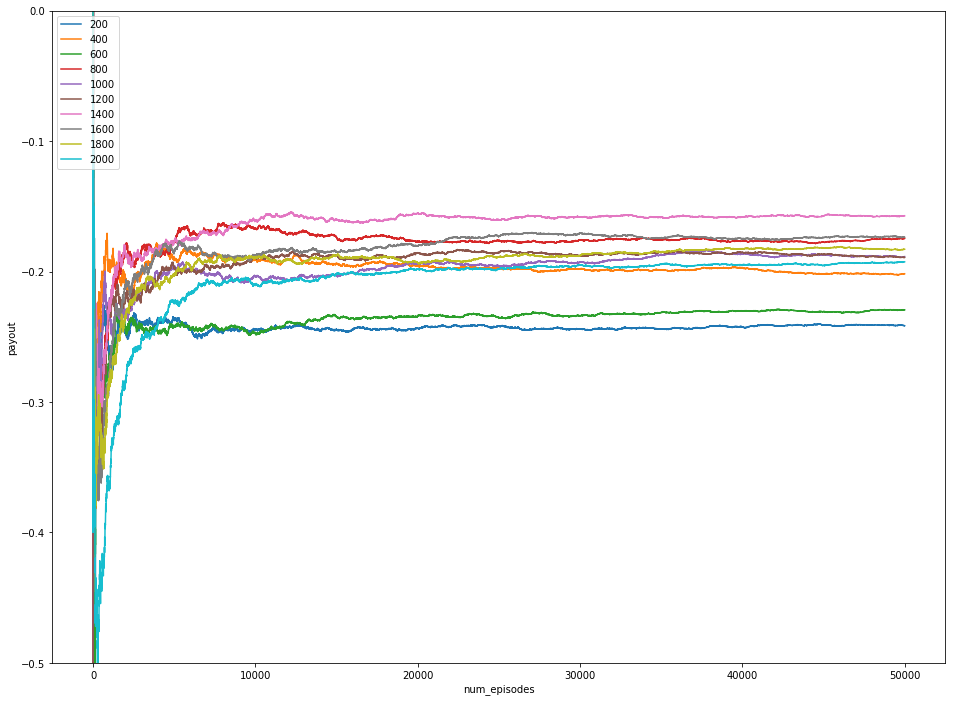

In [17]:
import gym
import matplotlib.pyplot as plt
from gym import wrappers
env = gym.make('Blackjack-v0')

num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 50 # num_rounds simulated over num_samples


num_episodes_values = range(200, 2200, 200)

plt.figure(num=None, figsize=(16, 12))
plt.clf()
                          
# Run simulations over different values of 'num_episodes_to_train' to find the one with best payout
for num_episodes_value in num_episodes_values:
    total_payout = 0 # to store total payout over 'num_rounds'
    average_payouts = [] # to store total payout over 'num_rounds' after 'num_sample' simulations
    agent = Agent(env=env, epsilon=1.0, alpha=0.8, gamma=0.9, num_episodes_to_train=num_episodes_value)

    observation = env.reset()
    for sample in range(num_samples):
        round = 1
        # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
        while round <= num_rounds:
            action = agent.choose_action(observation)
            next_observation, payout, is_done, _ = env.step(action)
            agent.learn(observation, action, payout, next_observation)
            total_payout += payout
            observation = next_observation
            if is_done:
                observation = env.reset() # Environment deals new cards to player and dealer
                round += 1
                average_payouts.append(total_payout/(sample*num_rounds + round))

    plt.plot(average_payouts)
    print ("Average payout after {} rounds after training for {} episodes is {}".format(num_rounds, num_episodes_value, total_payout/(num_samples)))
    

# Plot payout per 1000 episodes for each value of 'num_episodes_to_train' in the same graph
plt.xlabel('num_episodes')
plt.ylabel('payout')
plt.legend(["{}".format(i) for i in num_episodes_values], loc='upper left')
plt.ylim(-0.5,0) # To zoom into this region
plt.show()
env.close()



#### Rate of decrease of exploration factor (epsilon)
*epsilon* is plotted during the training process to showcase the rate of its decrease.

[2018-12-20 15:25:52,546] Making new env: Blackjack-v0


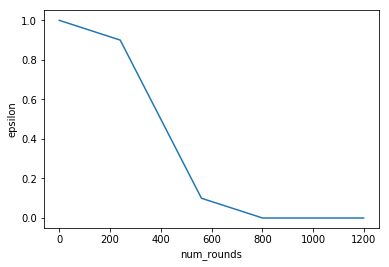

Average payout after 800 rounds is -295.0


In [9]:
env = gym.make('Blackjack-v0')
# env = wrappers.Monitor(env, './logs/blackjack-Q', False, True)

total_payout = 0 # to store total payout over 'num_rounds'
average_payouts = []
agent = Agent(env=env, epsilon=1.0, alpha=0.8, gamma=0.9, num_episodes_to_train=800)

num_rounds = 800 # Payout calculated over num_rounds
num_samples = 1 # num_rounds simulated over num_samples


observation = env.reset()
for sample in range(num_samples):
    round = 1
    epsilon_values = []
    # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
    while round <= num_rounds:
        epsilon_values.append(agent.epsilon)
        action = agent.choose_action(observation)
        next_observation, payout, is_done, _ = env.step(action)
        agent.learn(observation, action, payout, next_observation)
        total_payout += payout
        observation = next_observation
        if is_done:
            observation = env.reset() # Environment deals new cards to player and dealer
            round += 1
            average_payouts.append(total_payout/(sample*num_rounds + round))

# Plot epsilon over rounds to show rate of its decrease
plt.figure(2)
plt.xlabel("num_rounds")
plt.ylabel("epsilon")
plt.plot(epsilon_values)
plt.show()
print ("Average payout after {} rounds is {}".format(num_rounds, total_payout/(num_samples)))

### Final Model

The final model is built by picking the best parameters from the search and the average payout per 1000 rounds is plotted over 1000 trials.

[2018-12-20 15:27:01,183] Making new env: Blackjack-v0


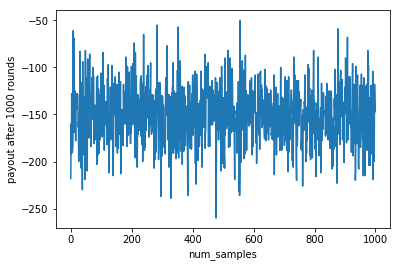

Average payout after 1000 rounds is -149.815


In [14]:
import gym
env = gym.make('Blackjack-v0')
# env = wrappers.Monitor(env, './logs/blackjack-Q', False, True)
import matplotlib.pyplot as plt

agent = Agent(env=env, epsilon=1.0, alpha=0.5, gamma=0.2, num_episodes_to_train=800)

num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 1000 # num_rounds simulated over num_samples

average_payouts = []

observation = env.reset()
for sample in range(num_samples):
    round = 1
    total_payout = 0 # to store total payout over 'num_rounds'
    # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
    while round <= num_rounds:
        action = agent.choose_action(observation)
        next_observation, payout, is_done, _ = env.step(action)
        agent.learn(observation, action, payout, next_observation)
        total_payout += payout
        observation = next_observation
        if is_done:
            observation = env.reset() # Environment deals new cards to player and dealer
            round += 1
    average_payouts.append(total_payout)

# Plot payout per 1000 episodes for each value of 'sample'
plt.plot(average_payouts)           
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()      
    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/(num_samples)))

### Analyzing the strategy learned

In [15]:
import gym
env = gym.make('Blackjack-v0')

agent = Agent(env=env, epsilon=1.0, alpha=0.5, gamma=0.2, num_episodes_to_train=800)

num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 100 # num_rounds simulated over num_samples

payouts = []

observation = env.reset()
round = 1
total_payout = 0 # to store total payout over 'num_rounds'
# Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
while round <= num_rounds * num_samples:
    action = agent.choose_action(observation)
    next_observation, payout, is_done, _ = env.step(action)
    agent.learn(observation, action, payout, next_observation)
    payouts.append(payout)
    observation = next_observation
    if is_done:
        observation = env.reset() # Environment deals new cards to player and dealer
        round += 1

num_observations = 0        
list_players_hand = range(1, 22)
list_dealers_upcard = range(1, 11)

def readable_action(observation, agent):
    """ 
    Pass observation to agent and get human readable action
    H is hit, S is stick and '-' means the state is unseen and a random action is taken
    """
    if observation not in agent.Q:
        action = "-"
    else:
        action = "H" if agent.choose_action(observation) else "S"    
    return action

# Print headers to give more information about output
print ("{:^10} | {:^50} | {:^50}".format("Player's","Dealer's upcard when ace is not usable", "Dealer's upcard when ace is usable"))
print ("{0:^10} | {1} | {1}".format("Hand", [str(upcard) if not upcard==10 else 'A' 
                                                        for upcard in list_dealers_upcard]))
print (''.join(['-' for _ in range(116)]))
for players_hand in list_players_hand:
    actions_usable = []
    actions_not_usable = []
    for dealers_upcard in list_dealers_upcard:
        observation = (players_hand, dealers_upcard, False)
        actions_not_usable.append(readable_action(observation, agent))
        observation = (players_hand, dealers_upcard, True)
        actions_usable.append(readable_action(observation, agent))
    
    print ("{:>10} | {} | {}".format(players_hand, actions_not_usable, actions_usable))

    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(payouts)/num_samples))

[2018-12-20 15:28:02,140] Making new env: Blackjack-v0


 Player's  |       Dealer's upcard when ace is not usable       |         Dealer's upcard when ace is usable        
   Hand    | ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A'] | ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A']
--------------------------------------------------------------------------------------------------------------------
         1 | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'] | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
         2 | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'] | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
         3 | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-'] | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
         4 | ['H', 'S', 'S', 'H', 'S', 'H', 'H', 'H', 'H', 'H'] | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
         5 | ['S', 'H', 'H', 'H', 'S', 'H', 'H', 'S', 'H', 'H'] | ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-']
         6 | ['S', 'H', 'S', 'H', 'H', 'H', 'S', 'H', 'H', 'H'] 